In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm,trange

import ehtim as eh
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# num visibility values, split into real/complex
INPUT_SIZE = 1030*2
INPUT_SHAPE = (1030, 2)

# n pixels in image
OUTPUT_SIZE = 28*28
OUTPUT_SHAPE = (28, 28)
to_display = eh.image.load_txt('eht-imaging/models/avery_sgra_eofn.txt');
to_display = to_display.resample_square(28)

def show_image(arr):
    """Displays image given a ndarray of pixels in shape (28,28)."""
    to_display.imvec = arr.reshape(784)
    to_display.display()

Welcome to eht-imaging! v  1.1.1
Loading text image:  eht-imaging/models/avery_sgra_eofn.txt


In [3]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.dense = nn.Sequential(
#             nn.Dropout(p=.1),
            nn.Linear(INPUT_SIZE, 56*56),
            nn.ReLU(),
        )

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, padding=1),
        )
        
        self.loss = nn.MSELoss()

    def forward(self, x):
        """
        x : shape(batch, 1030, 2)
        
        out : shape(batch, 28, 28)
        """
        x = x.flatten(start_dim=1)
        x = self.dense(x)
        
        x = x.view(-1,1,56,56)
        x = self.conv(x)
        x = x.squeeze(dim=1)
        
        return x

In [4]:
# load trained model
model = ConvNet()
model.load_state_dict(torch.load("models/1dense1convpool/noisy_1dense1convpool_20kimg_10ep.pickle"))

<All keys matched successfully>

In [5]:
n = 11
x, y = np.empty((n, *INPUT_SHAPE)), np.empty((n, *OUTPUT_SHAPE))

for i in trange(n):
    obs = eh.obsdata.load_uvfits('mnistinputs/obs{}.fits'.format(i))
    im = eh.image.load_fits('mnistoutputs/img{}.fits'.format(i))

    # separate real and imaginary components of visibilities
    x[i] = np.asarray((obs.data['vis'].real, obs.data['vis'].imag)).T
    y[i] = im.imvec.reshape(28, 28)

x = torch.as_tensor(x, dtype=torch.float)
y = torch.as_tensor(y, dtype=torch.float)

Loading uvfits:  mnistinputs/obs0.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/img0.fits
Loading uvfits:  mnistinputs/obs1.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/img1.fits
Loading uvfits:  mnistinputs/obs2.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/img2.fits
Loading uvfits:  mnistinputs/obs3.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/img3.fits
Loading uvfits:  mnistinputs/obs4.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/img4.fits
Loading uvfits:  mnistinputs/obs5.fits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
Loading fits image:  mnistoutputs/im

Target

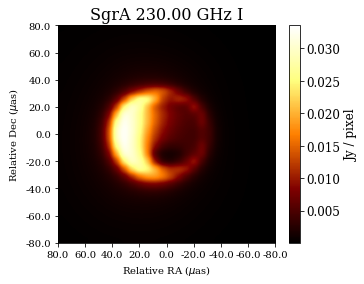

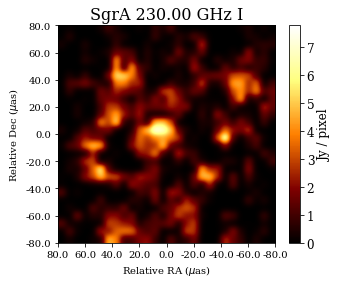

Target

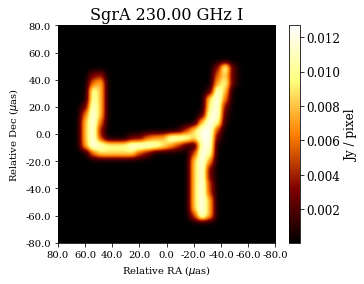

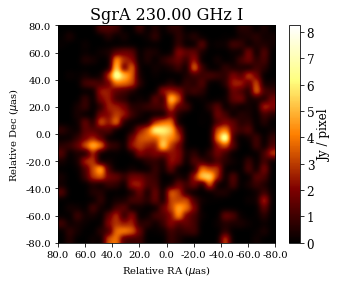

Target

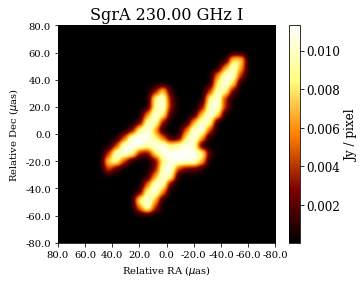

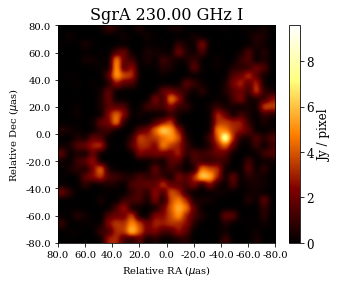

Target

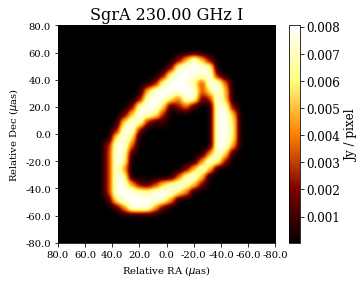

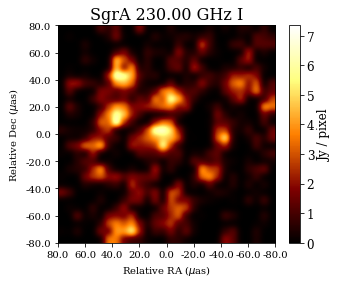

Target

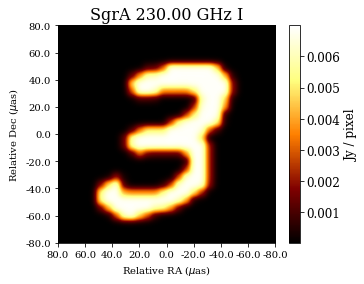

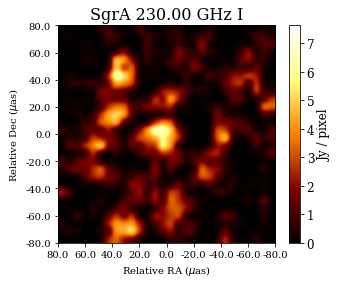

Target

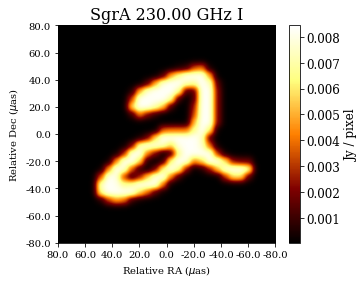

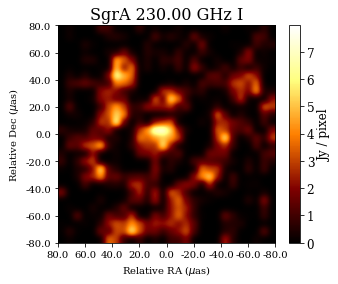

Target

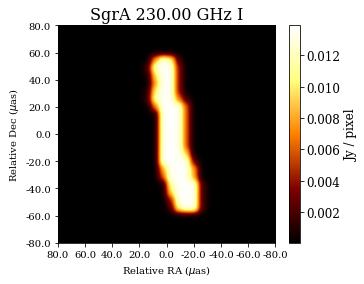

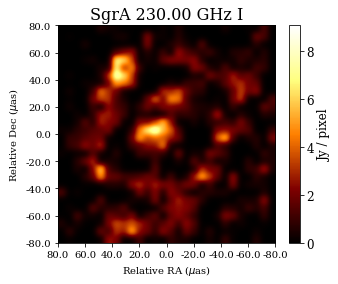

Target

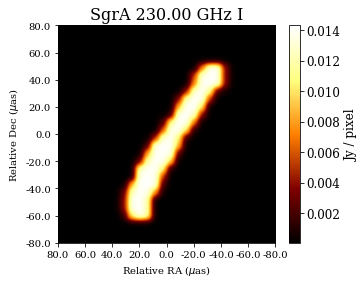

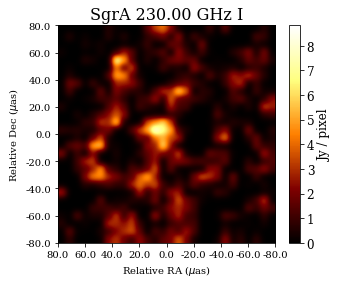

Target

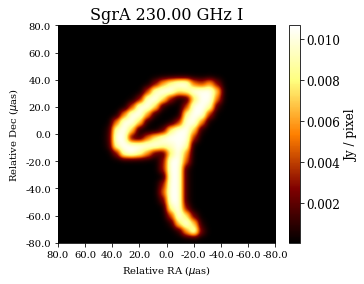

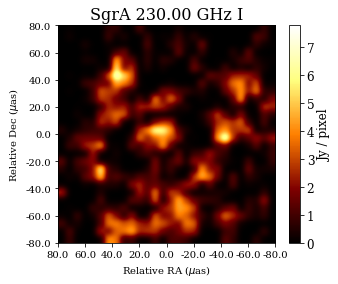

Target

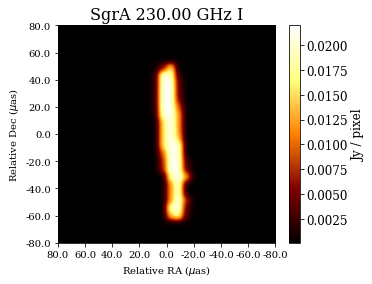

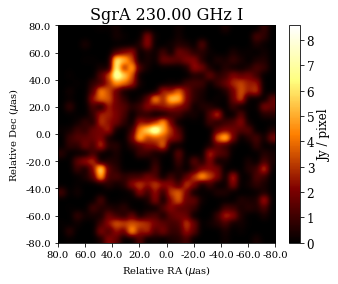

Target

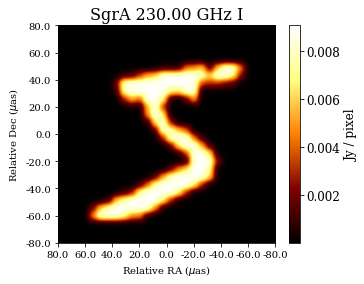

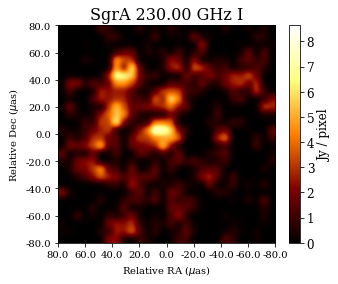


average loss:  8.720682263374329


In [6]:
# Prevent torch from saving gradients so it evaluates faster
testset = torch.utils.data.TensorDataset(x, y)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

with torch.no_grad():
    tot_loss = 0
    cnt = 1
    for data in tqdm(testloader):
        # get the inputs, outputs
        # see training block for shape desc.
        vis, imgs = data

        # scale vis up so avg pixel is 1
        vis = INPUT_SIZE * vis
        
        # Generate image and sum up loss
        outs = model(vis)
        tot_loss += model.loss(outs, OUTPUT_SIZE * imgs).item()

        print('Target', end='')
        show_image(imgs[0].numpy())
        #print('Reconstruction')
        show_image(outs[0].numpy())
        
        cnt += 1
    
print("average loss: ", tot_loss/cnt)